In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import Node2Vec, TransformerConv
from torch_geometric.data import Data
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import networkx as nx

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

all_nodes = pd.unique(pd.concat([train_df['node1'], train_df['node2'], test_df['node1'], test_df['node2']]))
node2idx = {node: idx for idx, node in enumerate(all_nodes)}
n_nodes = len(node2idx)

train_df['node1'] = train_df['node1'].map(node2idx)
train_df['node2'] = train_df['node2'].map(node2idx)
test_df['node1'] = test_df['node1'].map(node2idx)
test_df['node2'] = test_df['node2'].map(node2idx)

all_edges = list(map(tuple, train_df[['node1', 'node2']].values.tolist()))
train_edges, val_edges = train_test_split(all_edges, test_size=0.1, random_state=42)

edge_index = torch.tensor(train_edges, dtype=torch.long).t()
reversed_edges = edge_index[[1, 0], :]
edge_index = torch.cat([edge_index, reversed_edges], dim=1)
data = Data(edge_index=edge_index)

In [ ]:
in_deg = torch.zeros(n_nodes, dtype=torch.long)
out_deg = torch.zeros(n_nodes, dtype=torch.long)

for src, dst in edge_index.t():
    out_deg[src] += 1
    in_deg[dst] += 1
    
MAX_DEGREE = 500
in_deg = torch.clamp(in_deg, max=MAX_DEGREE - 1)
out_deg = torch.clamp(out_deg, max=MAX_DEGREE - 1)

In [43]:
MAX_SPD = 10
G = nx.Graph()
G.add_edges_from(train_edges)
spd_dict = dict(nx.all_pairs_shortest_path_length(G, cutoff=MAX_SPD))
spd_matrix = torch.full((n_nodes, n_nodes), MAX_SPD, dtype=torch.long)
for src, targets in spd_dict.items():
    for dst, dist in targets.items():
        spd_matrix[src, dst] = min(dist, MAX_SPD - 1)

In [44]:
# centrality
pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
centrality_tensor = torch.zeros((n_nodes, 3))

for node in range(n_nodes):
    centrality_tensor[node, 0] = pagerank.get(node, 0.0)
    centrality_tensor[node, 1] = betweenness.get(node, 0.0)
    centrality_tensor[node, 2] = closeness.get(node, 0.0)

In [45]:
node2vec = Node2Vec(edge_index, embedding_dim=64, walk_length=20, context_size=10,
                    walks_per_node=10, num_nodes=n_nodes, sparse=True)
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer_n2v = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train_node2vec():
    node2vec.train()
    for epoch in range(1, 31):
        total_loss = 0
        pbar = tqdm(loader, desc=f"Node2Vec Epoch {epoch}", leave=False)
        for pos_rw, neg_rw in pbar:
            optimizer_n2v.zero_grad()
            loss = node2vec.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer_n2v.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        if epoch % 5 == 0:
            tqdm.write(f"Node2Vec Epoch {epoch}, Total Loss: {total_loss:.4f}")

train_node2vec()
x_raw = node2vec.embedding.weight.detach()
x_input = torch.cat([x_raw, centrality_tensor], dim=1)

Node2Vec Epoch 5, Total Loss: 110.8138


Node2Vec Epoch 10, Total Loss: 84.7706


Node2Vec Epoch 15, Total Loss: 77.8829


Node2Vec Epoch 20, Total Loss: 74.9276


Node2Vec Epoch 25, Total Loss: 73.3978


Node2Vec Epoch 30, Total Loss: 72.5895


In [107]:
class Graphormer(nn.Module):
    def __init__(self, embedding_dim=67, hidden_dim=64, heads=4):
        super().__init__()
        self.input_proj = nn.Linear(embedding_dim, hidden_dim)
        self.in_deg_emb = nn.Embedding(500, embedding_dim)
        self.out_deg_emb = nn.Embedding(500, embedding_dim)
        self.spd_emb = nn.Embedding(11, hidden_dim)

        self.encoder = nn.Sequential(
            TransformerConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=0.2),
            nn.ReLU(),
            TransformerConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=0.2)
        )

        self.edge_mlp = nn.Sequential(
            nn.Linear(5 * hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        self.dropout = nn.Dropout(0.2)

    def encode(self, x, edge_index, in_deg_ids, out_deg_ids):
        x = self.input_proj(x)
        x = x + self.input_proj(self.in_deg_emb(in_deg_ids)) + self.input_proj(self.out_deg_emb(out_deg_ids))
        x = self.encoder[0](x, edge_index)
        x = self.encoder[1](x)
        x = self.encoder[2](x, edge_index)
        return x

    def decode(self, z, edge_index, spd_matrix):
        src, dst = edge_index
        hadamard = z[src] * z[dst]
        l1 = torch.abs(z[src] - z[dst])

        spd_ids = spd_matrix[src, dst]
        spd_feat = self.spd_emb(spd_ids)
        mask = (spd_ids < 10).float().unsqueeze(1)
        spd_feat = spd_feat * mask

        edge_feat = torch.cat([z[src], z[dst], hadamard, l1, spd_feat], dim=1)
        edge_feat = self.dropout(edge_feat)
        
        return self.edge_mlp(edge_feat).squeeze()


In [108]:
model = Graphormer(embedding_dim=x_input.size(1))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
pos_weight = torch.tensor([1.5])  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

clip_value = 1.0

In [99]:
# Instead of hard negative sampling
def sample_neg_edge_fast(edge_index, num_nodes, num_samples):
    edge_set = set(map(tuple, edge_index.t().tolist()))
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in edge_set:
            neg_edges.add((u, v))
    return torch.tensor(list(neg_edges), dtype=torch.long).t()

In [109]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x_input, data.edge_index, in_deg, out_deg)

    pos_edge = edge_index
    neg_edge = sample_neg_edge_fast(edge_index, n_nodes, pos_edge.size(1))

    pos_pred = model.decode(z, pos_edge, spd_matrix)
    pos_label = torch.ones(pos_pred.size(0))

    neg_pred = model.decode(z, neg_edge, spd_matrix)
    neg_label = torch.zeros(neg_pred.size(0))

    pred = torch.cat([pos_pred, neg_pred])
    labels = torch.cat([pos_label, neg_label])

    loss = criterion(pred, labels)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
    scheduler.step()
    return loss.item()

for epoch in tqdm(range(1, 151), desc="Training"):
    loss = train()
    if epoch % 10 == 0:
        tqdm.write(f"Epoch {epoch}, Loss: {loss:.8f}")

Training:   7%|▋         | 10/150 [00:10<02:26,  1.05s/it]

Epoch 10, Loss: 0.55855817


Training:  13%|█▎        | 20/150 [00:21<02:13,  1.03s/it]

Epoch 20, Loss: 0.34813425


Training:  20%|██        | 30/150 [00:31<02:05,  1.05s/it]

Epoch 30, Loss: 0.18734917


Training:  27%|██▋       | 40/150 [00:42<01:57,  1.06s/it]

Epoch 40, Loss: 0.12946169


Training:  33%|███▎      | 50/150 [00:52<01:47,  1.08s/it]

Epoch 50, Loss: 0.09601518


Training:  40%|████      | 60/150 [01:03<01:35,  1.06s/it]

Epoch 60, Loss: 0.07488960


Training:  47%|████▋     | 70/150 [01:13<01:24,  1.06s/it]

Epoch 70, Loss: 0.06548190


Training:  53%|█████▎    | 80/150 [01:24<01:14,  1.06s/it]

Epoch 80, Loss: 0.05883764


Training:  60%|██████    | 90/150 [01:35<01:03,  1.07s/it]

Epoch 90, Loss: 0.05299313


Training:  67%|██████▋   | 100/150 [01:45<00:52,  1.05s/it]

Epoch 100, Loss: 0.04952390


Training:  73%|███████▎  | 110/150 [01:56<00:42,  1.06s/it]

Epoch 110, Loss: 0.04643441


Training:  80%|████████  | 120/150 [02:07<00:32,  1.07s/it]

Epoch 120, Loss: 0.04415439


Training:  87%|████████▋ | 130/150 [02:17<00:20,  1.05s/it]

Epoch 130, Loss: 0.04389695


Training:  93%|█████████▎| 140/150 [02:28<00:10,  1.06s/it]

Epoch 140, Loss: 0.04230328


Training: 100%|██████████| 150/150 [02:39<00:00,  1.06s/it]

Epoch 150, Loss: 0.04029765


In [110]:
model.eval()
with torch.no_grad():
    z = model.encode(x_input, data.edge_index, in_deg, out_deg)
    val_edges = val_edges.t() if val_edges.shape[1] == 2 else val_edges

    val_neg_edges = sample_neg_edge_fast(edge_index, n_nodes, val_edges.size(1))
    val_pos_scores = model.decode(z, val_edges, spd_matrix)
    val_neg_scores = model.decode(z, val_neg_edges, spd_matrix)
    val_scores = torch.cat([val_pos_scores, val_neg_scores])

    print("Logits sample:", val_scores[:10].cpu().numpy())

    val_labels = torch.cat([torch.ones(val_pos_scores.size(0)), torch.zeros(val_neg_scores.size(0))])
    val_probs = torch.sigmoid(val_scores).cpu().numpy()
    val_labels = val_labels.cpu().numpy()

best_f1 = 0
best_threshold = 0.5
for t in np.arange(0.3, 0.6, 0.01):
    val_preds = (val_probs > t).astype(int)
    f1 = f1_score(val_labels, val_preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold by F1: {best_threshold:.2f} (F1 = {best_f1:.4f})")

Logits sample: [-0.12576875 -0.11187551 -0.3574853  -0.11812923 -0.12755501 -0.0998562
 -0.11374953 -0.12623239 -0.10487724 -0.11438506]
Best threshold by F1: 0.30 (F1 = 0.6670)


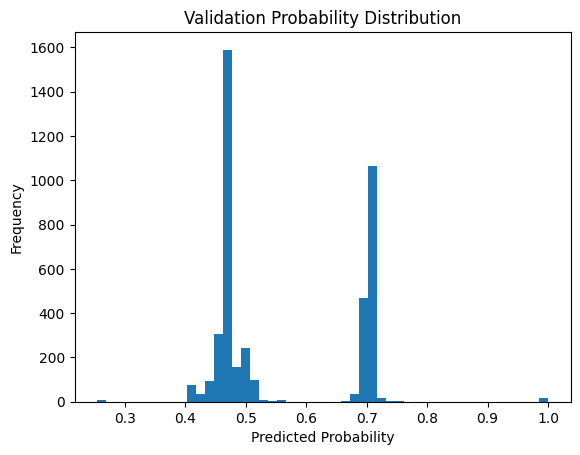

Labels count: [2109 2109]
Preds > 0.5: 1848
Preds < 0.5: 2370


In [111]:
import matplotlib.pyplot as plt

plt.hist(val_probs, bins=50)
plt.title("Validation Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

print("Labels count:", np.bincount(val_labels.astype(int)))

print("Preds > 0.5:", np.sum(val_probs > 0.5))
print("Preds < 0.5:", np.sum(val_probs < 0.5))

In [112]:
test_edges = torch.tensor(test_df[['node1', 'node2']].values.T, dtype=torch.long)
with torch.no_grad():
    scores = model.decode(z, test_edges, spd_matrix)
    probs = torch.sigmoid(scores).cpu().numpy()
    preds = (probs > best_threshold).astype(int)

submission = test_df[['idx']].copy()
submission.rename(columns={'idx': 'predict_nodepair_id'}, inplace=True)
submission['label'] = preds
submission.to_csv("submission.csv", index=False)
print("preds saved")

preds saved
